In [160]:
from utility_funcs import fix_date_time
import pandas as pd
import numpy as np
import seaborn as sn
import scipy as sp
import matplotlib.pyplot as plt
import reverse_geocoder as rg
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder
from scipy.stats import ttest_ind
from sklearn.naive_bayes import MultinomialNB
from math import pow, sqrt
from scipy.stats import mannwhitneyu, binom_test, chisquare, chi2_contingency

In [161]:
filepath = 'test_results.csv'
outpath = 'fixed_test_results.csv'
# fix_date_time(filepath=filepath, outpath=outpath)

In [162]:
test_df = pd.DataFrame.from_csv('fixed_test_results.csv')
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])
user_df = pd.DataFrame.from_csv('user_table.csv')

In [163]:
where_control = test_df.where(test_df['test'] == 0)
where_test = test_df.where(test_df['test'] == 1)
invalid_control = ~((where_control['price'] == 39) | pd.isnull(where_control['price']))
invalid_test = ~((where_test['price'] == 59) | pd.isnull(where_test['price']))
valid_test_or_control = ~(invalid_control | invalid_test)
dropped_invalid_df = test_df.where(~valid_test_or_control).dropna(how='all')
test_df = test_df.where(valid_test_or_control).dropna(how='all')
test_df.reset_index(level=0, inplace=True)
user_df.reset_index(level=0, inplace=True)
df = test_df.merge(user_df, on='user_id')
df.test = df.test.astype(int)
df.converted = df.converted.astype(int)

In [164]:
# df.timestamp.dt.minute
# df.timestamp.dt.month
# df.timestamp.dt.hour
df.columns
admin1 = []
admin2 = []
country = []
user_id = df.user_id
geosearch = rg.search(list(zip(df.lat, df.long)))
weird = ['Nunavut', 'St.-Petersburg', ]
index = 0
for item in geosearch:
    admin1.append(item['admin1'])
    admin2.append(item['admin2'])
    country.append(item['cc'])
    # if item['admin1'] in weird:
    #     print(item)
geocode_df = pd.DataFrame()
geocode_df['user_id']=user_id
admin1 = pd.Series(admin1)
admin2 = pd.Series(admin2)
country = pd.Series(country)
# admin1.unique()
# df[['lat', 'long']]
geocode_df['State'] = admin1
geocode_df['rg_country'] = country

combdf = df.merge(geocode_df, on=['user_id'])
non_usa = combdf.where(combdf['rg_country'] != 'US').dropna(how='all').copy()
fixeddf = combdf.where(combdf['rg_country'] == 'US').dropna(how='all').copy()
print(fixeddf.shape)
print(non_usa.shape)
# st_l = fixeddf.State.unique()
# for st in ["Alabama", "Alaska", "Arizona", "Arkansas",  "California", "Colorado", "Connecticut", "Delaware", "Florida", "Georgia", "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa", "Kansas", "Kentucky", "Louisiana", "Maine", "Maryland", "Massachusetts", "Michigan", "Minnesota", "Mississippi", "Missouri", "Montana", "Nebraska", "Nevada", "New Hampshire", "New Jersey", "New Mexico", "New York", "North Carolina", "North Dakota", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Vermont", "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming"]:
#     if st not in st_l:
#         print(st)
fixeddf['city_state'] = fixeddf.city.map(str) + '_' + fixeddf.State
df = fixeddf

(274765, 14)
(529, 14)


In [165]:
df.loc()[0:20]

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long,State,rg_country,city_state
0,604839.0,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0.0,39.0,0.0,Buffalo,USA,42.89,-78.86,New York,US,Buffalo_New York
1,624057.0,2015-05-10 21:08:46,seo-google,mobile,android,0.0,39.0,0.0,Lakeville,USA,44.68,-93.24,Minnesota,US,Lakeville_Minnesota
2,317970.0,2015-04-04 15:01:23,ads-bing,mobile,android,0.0,39.0,0.0,Parma,USA,41.38,-81.73,Ohio,US,Parma_Ohio
3,685636.0,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1.0,59.0,0.0,Fayetteville,USA,35.07,-78.90,North Carolina,US,Fayetteville_North Carolina
4,820854.0,2015-05-24 11:04:40,ads_facebook,web,mac,0.0,39.0,0.0,Fishers,USA,39.95,-86.02,Indiana,US,Fishers_Indiana
5,169971.0,2015-04-13 12:07:08,ads-google,mobile,iOS,0.0,39.0,0.0,New York,USA,40.67,-73.94,New York,US,New York_New York
6,798371.0,2015-03-15 08:19:29,ads-bing,mobile,android,1.0,59.0,1.0,East Orange,USA,40.77,-74.21,New Jersey,US,East Orange_New Jersey
7,447194.0,2015-03-28 12:28:10,ads_facebook,web,windows,1.0,59.0,0.0,Dayton,USA,39.78,-84.20,Ohio,US,Dayton_Ohio
8,431639.0,2015-04-24 12:42:18,ads_facebook,web,windows,1.0,59.0,0.0,Richmond,USA,37.53,-77.47,Virginia,US,Richmond_Virginia
9,590182.0,2015-04-17 13:30:04,ads-google,web,windows,0.0,39.0,0.0,Bloomfield Township,USA,42.58,-83.27,Michigan,US,Bloomfield Township_Michigan


In [166]:
def compute_results_features(df):
    results_df = pd.DataFrame()
    results_df['class'] = pd.Series(['Control', 'Test'])
    results_df['Visitors'] = df.groupby(['test'])['user_id'].count()
    results_df['CountConverted'] = df.groupby(df['test'])['converted'].sum()
    results_df['SalesRevenue'] = df.groupby(['test'])['price'].sum()
    results_df['ConvertRate'] = results_df.CountConverted / results_df.Visitors
    results_df['price'] = pd.Series([39, 59])
    results_df['RevenueRate'] = results_df.ConvertRate * results_df.price
    results_df['sigma_rate']= np.sqrt((results_df.ConvertRate * (1 - results_df.ConvertRate)) / results_df.Visitors)
    results_df.set_index(['class'], inplace=True)
    return results_df


results_df = compute_results_features(df)
results_df

,Visitors,CountConverted,SalesRevenue,ConvertRate,price,RevenueRate,sigma_rate
class,,,,,,,
Control,175933,3482.0,6861387.0,0.019792,39,0.771873,0.000332
Test,98832,1526.0,5831088.0,0.015440,59,0.910980,0.000392


In [167]:
def test_results_distros(results_df):
    converts = results_df.CountConverted
    nonconverts = results_df.Visitors - results_df.CountConverted
    rates = results_df.ConvertRate
    print("binomial test same rates: control: %0.3e, test: %0.3e" % (
        binom_test([converts[0], nonconverts[0]], p=rates[0]), 
     binom_test([converts[1], nonconverts[1]], p=rates[1])))
    print("binomial test, opposite rates: %0.3e, test: %0.3e" % (
        binom_test([converts[0], nonconverts[0]], p=rates[1]), 
     binom_test([converts[1], nonconverts[1]], p=rates[0])))
    # mannwhitneyu(df.where(df.test == 1).dropna(how='all').converted, 
    #              df.where(df.test == 0).dropna(how='all').converted)
    
    chidf = pd.DataFrame()
    chidf['success'] = converts
    chidf['failure'] = nonconverts
    chiresultdf = pd.DataFrame()
    chires = chi2_contingency(chidf)
    restbl = chires[3]
    chiresultdf['class'] = ['Control', 'Test']
    chiresultdf.set_index(['class'], inplace=True)
    chiresultdf['success'] = [restbl[0][0], restbl[1][0]]
    chiresultdf['failure'] = [restbl[0][1], restbl[1][1]]
    print("statistic: %0.3f\np=%0.3e\ndeg_free:%d\nexpected: %s" % (chires[0], chires[1], chires[2], chiresultdf))
test_results_distros(results_df)

binomial test same rates: control: 1.000e+00, test: 1.000e+00
binomial test, opposite rates: 1.065e-45, test: 2.114e-24
statistic: 66.715
p=3.137e-16
deg_free:1
expected:              success        failure
class                              
Control  3206.640089  172726.359911
Test     1801.359911   97030.640089


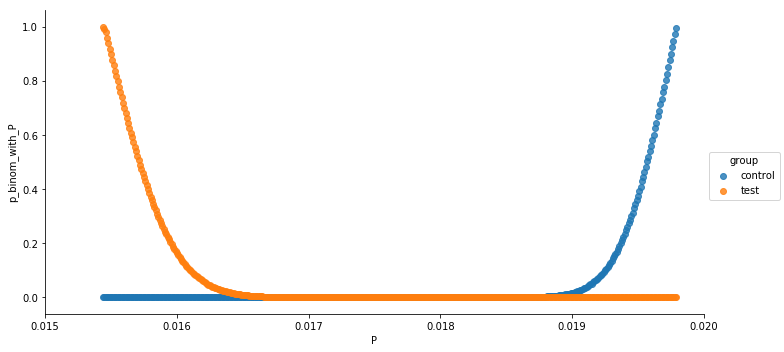

In [215]:
from floatrange import floatrange
from math import log10
def plot_dist_p_probs(results_df, factor=3):
    converts = results_df.CountConverted
    nonconverts = results_df.Visitors - results_df.CountConverted
    rates = results_df.ConvertRate
    xval = []
    cy = []
    vy = []
    for f in floatrange(min(rates), max(rates), (10 ** (int(log10(min(rates))) - factor))):
        xval.append(f)
        cy.append(binom_test([converts[0], nonconverts[0]], p=f))
        vy.append(binom_test([converts[1], nonconverts[1]], p=f))
    cprobs = pd.DataFrame()
    cprobs['P']=xval
    cprobs['p_binom_with_P'] = cy
    cprobs['group'] = 'control'
    vprobs = pd.DataFrame()
    vprobs['P']=xval
    vprobs['p_binom_with_P'] = vy
    vprobs['group'] = 'test'
    probs = pd.concat([cprobs, vprobs])
#     return probs
    facets = sn.lmplot(x='P', y='p_binom_with_P', data=probs, hue='group', fit_reg=False, aspect=2)
    facets.ax.set_xlim([0.015,0.020])
    plt.show()
plot_dist_p_probs(results_df, 4)

In [168]:
control_price = 39
test_price = 59
conversion_rate = 3484.0 / 176241.0
actual_new_rate = 1530.0 / 99053.0
print((actual_new_rate - conversion_rate )/conversion_rate)
#newConvRate = price*rate/new_rate
break_even = (control_price*conversion_rate)/test_price 
print((break_even - conversion_rate )/conversion_rate)
print(break_even) 
print(break_even * test_price)
print(conversion_rate * control_price)
rate_diff = abs(break_even - conversion_rate) 
rate_diff_percent = rate_diff / conversion_rate
print(rate_diff)
print(rate_diff_percent)
print(abs(actual_new_rate-conversion_rate)/conversion_rate)

-0.21863743682524253
-0.3389830508474576
0.013067237764467166
0.7709670281035628
0.7709670281035628
0.006701147571521623
0.3389830508474576
0.21863743682524253


In [169]:
from statsmodels.stats.power import GofChisquarePower
from statsmodels.stats.gof import chisquare_effectsize
chisqp = GofChisquarePower()
effect_size_break_even = sqrt(abs((break_even-conversion_rate)**2)/conversion_rate)
num_samp = chisqp.solve_power(effect_size=effect_size_break_even/2, alpha=0.05, n_bins=2, power=0.90)
corrected_num_samp = int(num_samp) + int((num_samp - int(num_samp)) > 0)
print(corrected_num_samp)

18503


In [170]:
from typing import Dict, List, Tuple
from sklearn.preprocessing import LabelEncoder
#make feature array for training a model
#check device, OS, city, source, hour of day
X = df[['timestamp', 'source', 'device', 'operative_system', 'city', 'State']].copy()
X['hour_of_day'] = X.timestamp.dt.hour
X['month_of_year'] = X.timestamp.dt.month
del X['timestamp']
X['city_state'] = X.city.map(str) + '_' + X.State
del X['city']
lbl_encs = dict()  # type: Dict['str', LabelEncoder]
for col in ['source', 'device', 'operative_system', 'city_state', 'State']:
    lbl_encs[col] = LabelEncoder()
    X[col] = lbl_encs[col].fit_transform(X[col])

Y = df.converted

In [171]:
X

,source,device,operative_system,State,hour_of_day,month_of_year,city_state
0,3,0,1,31,3,5,122
1,8,0,0,22,21,5,465
2,0,0,0,34,15,4,660
3,5,0,1,32,7,5,303
4,3,1,3,13,11,5,306
5,1,0,1,31,12,4,597
6,0,0,0,29,8,3,262
7,3,1,5,34,12,3,228
8,3,1,5,44,12,4,739
9,1,1,5,21,13,4,83


In [151]:
# Y

In [152]:
mnb = MultinomialNB()
mnb.fit(X, Y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [153]:
from sklearn.tree import DecisionTreeClassifier

In [154]:
clf = DecisionTreeClassifier().fit(X,Y)

In [155]:
features = pd.DataFrame()
features['names'] = X.columns
features['importance']=clf.feature_importances_
features

,names,importance
0,source,0.087558
1,device,0.014261
2,operative_system,0.023634
3,State,0.118694
4,hour_of_day,0.287629
5,month_of_year,0.123342
6,city_state,0.344882


In [156]:
from sklearn.linear_model import SGDClassifier
alpha = 1e-4
l1_ratio = 0.33
l1sgd = SGDClassifier(penalty='l1', loss='log', alpha=alpha, l1_ratio=l1_ratio)
l2sgd = SGDClassifier(penalty='l2', loss='log', alpha=alpha, l1_ratio=l1_ratio)
elastsgd = SGDClassifier(penalty='elasticnet', loss='log', alpha=alpha, l1_ratio=l1_ratio)
l1sgd.fit(X,Y)
l2sgd.fit(X,Y)
elastsgd.fit(X,Y)
features['l1sgd_coef'] = l1sgd.coef_[0]
features['l2sgd_coef'] = l2sgd.coef_[0]
features['elastsgd_coef'] = elastsgd.coef_[0]
features

,names,importance,l1sgd_coef,l2sgd_coef,elastsgd_coef
0,source,0.087558,-0.109250,-3.000282,0.000000
1,device,0.014261,0.000000,0.669676,0.901694
2,operative_system,0.023634,-0.060662,-3.281532,-0.228292
3,State,0.118694,-0.106027,-0.099227,0.000000
4,hour_of_day,0.287629,0.000000,-3.899167,0.000000
5,month_of_year,0.123342,-0.382010,-4.018379,1.405605
6,city_state,0.344882,-0.148993,-0.986252,0.000000


In [182]:
cdf = df.where(df.converted == 1).dropna(how='all')
ucdf = df.where(df.converted == 0).dropna(how='all')
ucdf

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long,State,rg_country,city_state
0,604839.0,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0.0,39.0,0.0,Buffalo,USA,42.89,-78.86,New York,US,Buffalo_New York
1,624057.0,2015-05-10 21:08:46,seo-google,mobile,android,0.0,39.0,0.0,Lakeville,USA,44.68,-93.24,Minnesota,US,Lakeville_Minnesota
2,317970.0,2015-04-04 15:01:23,ads-bing,mobile,android,0.0,39.0,0.0,Parma,USA,41.38,-81.73,Ohio,US,Parma_Ohio
3,685636.0,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1.0,59.0,0.0,Fayetteville,USA,35.07,-78.90,North Carolina,US,Fayetteville_North Carolina
4,820854.0,2015-05-24 11:04:40,ads_facebook,web,mac,0.0,39.0,0.0,Fishers,USA,39.95,-86.02,Indiana,US,Fishers_Indiana
5,169971.0,2015-04-13 12:07:08,ads-google,mobile,iOS,0.0,39.0,0.0,New York,USA,40.67,-73.94,New York,US,New York_New York
7,447194.0,2015-03-28 12:28:10,ads_facebook,web,windows,1.0,59.0,0.0,Dayton,USA,39.78,-84.20,Ohio,US,Dayton_Ohio
8,431639.0,2015-04-24 12:42:18,ads_facebook,web,windows,1.0,59.0,0.0,Richmond,USA,37.53,-77.47,Virginia,US,Richmond_Virginia
9,590182.0,2015-04-17 13:30:04,ads-google,web,windows,0.0,39.0,0.0,Bloomfield Township,USA,42.58,-83.27,Michigan,US,Bloomfield Township_Michigan
10,606479.0,2015-05-15 12:36:46,direct_traffic,web,mac,0.0,39.0,0.0,Des Plaines,USA,42.03,-87.90,Illinois,US,Des Plaines_Illinois


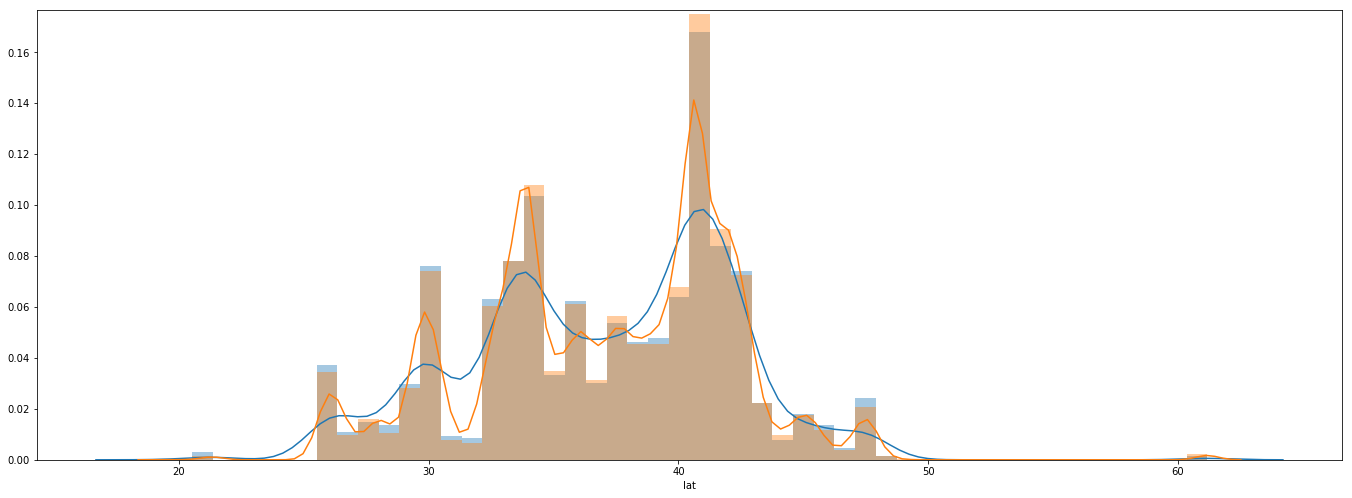

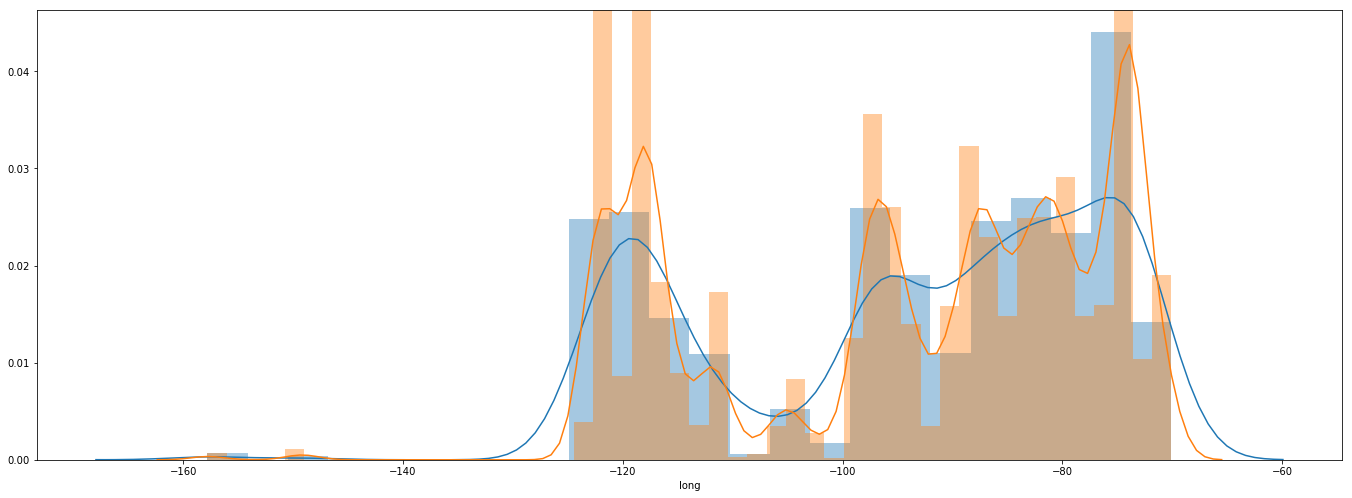

In [158]:
import seaborn as sn
a4_dims = (11.7*2, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sn.distplot(a=cdf['lat'])
ax = sn.distplot(a=ucdf['lat'])
# ax.set_xticks(np.arange(0,31,1))
# ax.set_autoscaley_on(False)
# ax.set_xlim([0,40])
plt.show()
fig, ax = plt.subplots(figsize=a4_dims)
ax = sn.distplot(a=cdf['long'])
ax = sn.distplot(a=ucdf['long'])
# ax.set_xticks(np.arange(0,31,1))
# ax.set_autoscaley_on(False)
# ax.set_xlim([0,40])
plt.show()

In [217]:
# sn.barplot()
# cdf['city_state'].value_counts() / df['city_state'].value_counts()
# df['city_state'].value_counts()

In [216]:
# df['State'].value_counts()

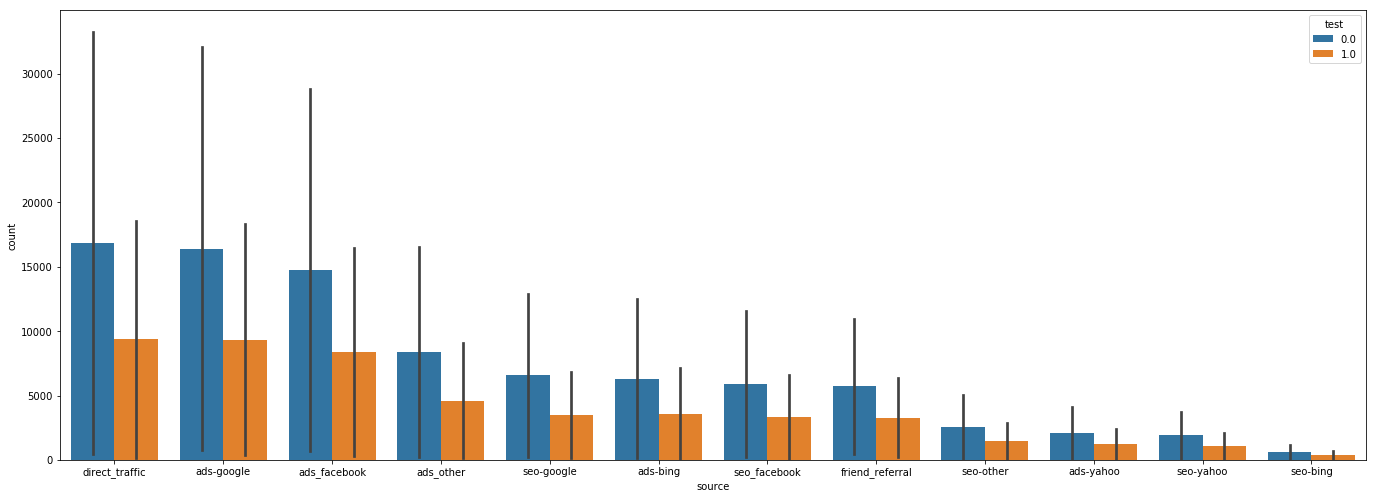

In [249]:
fig, ax = plt.subplots(figsize=a4_dims)
sn.barplot(x='source', y='count', hue='test', ax=ax,
           data=pd.DataFrame(df.groupby(['test','converted'])['source'].value_counts()).rename(columns={'source':'count'}).reset_index())
plt.show()
# sn.barplot(x='source', data=df, hue='test')
# plt.show()
